# TIME SERIES

## Tabla de contenido

## Objetivos

## Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
#import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime

## Helper fucntions

In [3]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None 
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

## Carga de datos

Descargamos los datos de https://www.coindesk.com/price/bitcoin/

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [8]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


-> afinar la definición

In [9]:
# Only want closing price for each day
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


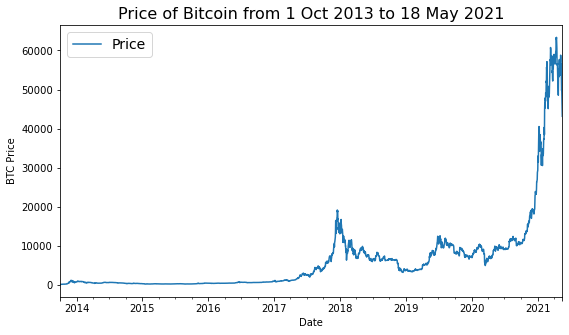

In [10]:
bitcoin_prices.plot(figsize=(9, 5))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

<b>Importando los datos usando el módulo CSV reader de python</b> (una alternativa a usar Pandas)

In [11]:
# Importing and formatting historical Bitcoin data with Python
timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

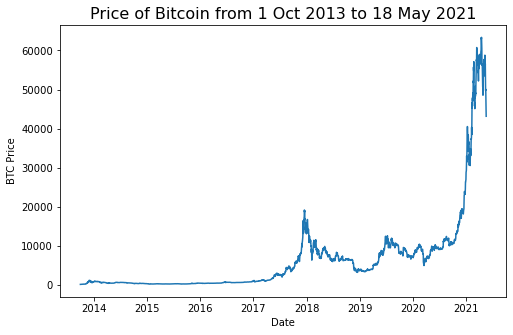

In [12]:
plt.figure(figsize=(8,5))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

### Train test split

NO puedo usar train_test_split de sklearn así nomás, pues hace una división aleatoria y esto es una serie temporal; el orden importa!!!

In [13]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [14]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

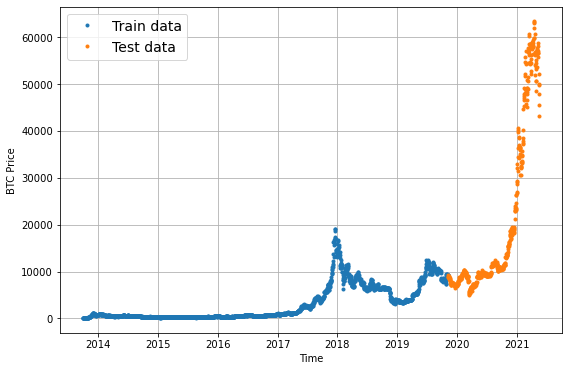

In [15]:
# Test out plotting function
plt.figure(figsize=(9, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelos a probar

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Same as 1, 	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

<b> <font color='green'>Naive Forecast</font></b>

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [16]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

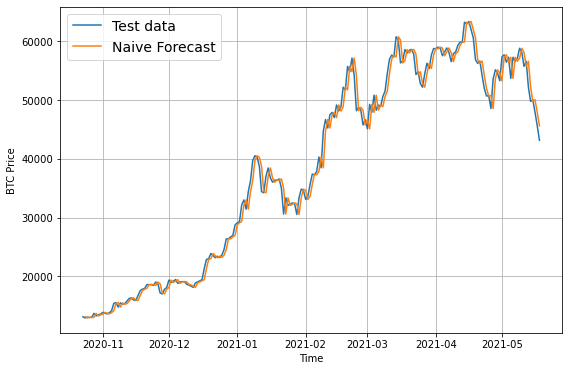

In [17]:
# Plot naive forecast
plt.figure(figsize=(9, 6))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

## Evaluando series temporales

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

<b> Implementando MASE </b>

In [18]:
# repaso reduce_mean

"""
tf.math.reduce_mean(
    input_tensor, axis=None, keepdims=False, name=None
)
"""

x = tf.constant( [ [1., 2.], [5.,3.] ])

print(x)

print(tf.math.reduce_mean(x)) # (1+2+5+3)/4  -> 2.75

print(tf.math.reduce_mean(x,axis=0)) # (1+5)/2 ; (2+3)/2

print(tf.math.reduce_mean(x,axis=1)) # (1+2)/2 ; (5+3)/2

print(tf.math.reduce_mean(x,axis=1,keepdims=True)) 

tf.Tensor(
[[1. 2.]
 [5. 3.]], shape=(2, 2), dtype=float32)
tf.Tensor(2.75, shape=(), dtype=float32)
tf.Tensor([3.  2.5], shape=(2,), dtype=float32)
tf.Tensor([1.5 4. ], shape=(2,), dtype=float32)
tf.Tensor(
[[1.5]
 [4. ]], shape=(2, 1), dtype=float32)


In [19]:
# ayuda para lo que sigue

y = np.array([1, 4, 7])


# yt - ty-1 : -> (7-4), (4-1)


print(y[1:]) # es desde la primera porque en la atrasada no tengo con qué restar al inicio
print(y[:-1])

y[1:] - y[:-1]



[4 7]
[1 4]


array([3, 3])

In [20]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [21]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182626

Función para computar las distintas métricas

In [22]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## <font color='#9400D3'> Format Data Part 2: Windowing our dataset </font>


--> antes usamos train/dev/test, ahora usaremos ventanas


Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [24]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [25]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [26]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite lsow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon 

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [28]:
# Ayuda de código


window_size = 3
horizon = 1


aux = np.array([10, 11, 12, 13, 14])


print(f"aux {aux}\n")


window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


print(f"window step: {window_step}\n")

window_indexes = window_step + np.expand_dims(np.arange(len(aux)-(window_size+horizon-1)), axis=0).T 


print(f"window indexes {window_indexes}")


aux[window_indexes]




#aux[[[0,1,2,3],[1,2,3,4]]]


aux [10 11 12 13 14]

window step: [[0 1 2 3]]

window indexes [[0 1 2 3]
 [1 2 3 4]]


array([[10, 11, 12, 13],
       [11, 12, 13, 14]])

In [29]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    #print(f"entrada: {x}\n")


    # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


    print(f"window setp: {window_step}\n")


    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
        # create 2D array of windows of size window_size
        # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # np.arange(4) -> [0,1,2,3]
    """
    np.expand_dims(np.arange(4),axis=0).T + [[1]]
    array([[1],
           [2],
           [3],
           [4]])
    """
        
        
        
    #print(f"window_indexes: {window_indexes}\n")


    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]


    #print(f"windowed_array: {windowed_array}\n")


    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [30]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[0 1 2 3 4 5 6 7]]



(2780, 2780)

In [31]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array 

In [32]:
"""
tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)
"""


"""

La exploraré primero sólo con las entradas y leugo tmb. con los targets

"""




window_size = 3
horizon = 1
data = np.array([10, 11, 12, 13, 14])


aux = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=None,
    sequence_length=window_size,
    sequence_stride=horizon
)


for a in aux:
    print(a)




tf.Tensor(
[[10 11 12]
 [11 12 13]
 [12 13 14]], shape=(3, 3), dtype=int32)


In [33]:
aux = tf.keras.utils.timeseries_dataset_from_array(
    prices,
    targets=None,
    sequence_length=WINDOW_SIZE,
    sequence_stride=HORIZON
)

for a in aux:
    print(a)
    

tf.Tensor(
[[ 123.65499  125.455    108.58483  118.67466  121.33866  120.65533
   121.795  ]
 [ 125.455    108.58483  118.67466  121.33866  120.65533  121.795
   123.033  ]
 [ 108.58483  118.67466  121.33866  120.65533  121.795    123.033
   124.049  ]
 [ 118.67466  121.33866  120.65533  121.795    123.033    124.049
   125.96116]
 [ 121.33866  120.65533  121.795    123.033    124.049    125.96116
   125.27966]
 [ 120.65533  121.795    123.033    124.049    125.96116  125.27966
   125.9275 ]
 [ 121.795    123.033    124.049    125.96116  125.27966  125.9275
   126.38333]
 [ 123.033    124.049    125.96116  125.27966  125.9275   126.38333
   135.24199]
 [ 124.049    125.96116  125.27966  125.9275   126.38333  135.24199
   133.20333]
 [ 125.96116  125.27966  125.9275   126.38333  135.24199  133.20333
   142.76333]
 [ 125.27966  125.9275   126.38333  135.24199  133.20333  142.76333
   137.92333]
 [ 125.9275   126.38333  135.24199  133.20333  142.76333  137.92333
   142.95166]
 [ 126.38333

   694.3125 ]], shape=(128, 7), dtype=float64)
tf.Tensor(
[[802.75333 748.43559 692.66914 668.86463 700.44843 694.3125  665.7975 ]
 [748.43559 692.66914 668.86463 700.44843 694.3125  665.7975  645.615  ]
 [692.66914 668.86463 700.44843 694.3125  665.7975  645.615   578.4125 ]
 [668.86463 700.44843 694.3125  665.7975  645.615   578.4125  641.91   ]
 [700.44843 694.3125  665.7975  645.615   578.4125  641.91    656.2725 ]
 [694.3125  665.7975  645.615   578.4125  641.91    656.2725  611.04499]
 [665.7975  645.615   578.4125  641.91    656.2725  611.04499 634.99   ]
 [645.615   578.4125  641.91    656.2725  611.04499 634.99    618.79   ]
 [578.4125  641.91    656.2725  611.04499 634.99    618.79    619.8425 ]
 [641.91    656.2725  611.04499 634.99    618.79    619.8425  545.7625 ]
 [656.2725  611.04499 634.99    618.79    619.8425  545.7625  561.535  ]
 [611.04499 634.99    618.79    619.8425  545.7625  561.535   622.22   ]
 [634.99    618.79    619.8425  545.7625  561.535   622.22    572.

  47500.8975242  47884.1828623  47005.1906489 ]], shape=(128, 7), dtype=float64)
tf.Tensor(
[[44716.68546906 46674.85168811 45237.47568925 47500.8975242
  47884.1828623  47005.1906489  49151.16757632]
 [46674.85168811 45237.47568925 47500.8975242  47884.1828623
  47005.1906489  49151.16757632 48125.99219541]
 [45237.47568925 47500.8975242  47884.1828623  47005.1906489
  49151.16757632 48125.99219541 48840.41447458]
 [47500.8975242  47884.1828623  47005.1906489  49151.16757632
  48125.99219541 48840.41447458 52165.30255522]
 [47884.1828623  47005.1906489  49151.16757632 48125.99219541
  48840.41447458 52165.30255522 51728.50879673]
 [47005.1906489  49151.16757632 48125.99219541 48840.41447458
  52165.30255522 51728.50879673 55719.2043617 ]
 [49151.16757632 48125.99219541 48840.41447458 52165.30255522
  51728.50879673 55719.2043617  54801.64864399]
 [48125.99219541 48840.41447458 52165.30255522 51728.50879673
  55719.2043617  54801.64864399 57128.64260647]
 [48840.41447458 52165.30255522

In [34]:
data = np.arange(1, 18)

# Definir la ventana de entrada (tamaño 3)
sequence_length = 3

# Crear el conjunto de datos usando timeseries_dataset_from_array
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=data[sequence_length:],  # Puedes ajustar esto según tus necesidades específicas
    sequence_length=sequence_length,
    sequence_stride=1,
    batch_size=32  # Ajusta el tamaño del lote según tus necesidades
)

# Imprimir las muestras generadas
for batch in dataset:
    inputs, targets = batch
    print("Entradas:", inputs.numpy(), "Siguiente valor:", targets.numpy())


    
print(type(dataset))    


Entradas: [[ 1  2  3]
 [ 2  3  4]
 [ 3  4  5]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]] Siguiente valor: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17]
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


## Turning windows into training and test sets

In [35]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [36]:
# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [38]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [39]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [40]:
train_labels.shape, y_train.shape

((2224, 1), (2229,))

Como los arreglos anteriores tienen distinto shape, debemos hacer el squeeze para compararlos apropiadamente (hay que deshacerse de la dimension con tamanio 1)

In [41]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [42]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## MODELOS

Probaremos distintos modelos.

### Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32) 
* 100 epochs 

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [43]:
# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")               
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 16s - loss: 3349.4385 - mae: 3349.4385 - mse: 30827878.0000

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 72ms/step - loss: 1741.2815 - mae: 1741.2815 - mse: 10461363.0000 - val_loss: 2307.4932 - val_mae: 2307.4932 - val_mse: 13466643.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 371.8236 - mae: 371.8236 - mse: 436114.5312

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 38ms/step - loss: 398.8690 - mae: 398.8690 - mse: 598683.3750 - val_loss: 2069.8584 - val_mae: 2069.8584 - val_mse: 10083934.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 294.4158 - mae: 294.4158 - mse: 260273.7812

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 43ms/step - loss: 225.2951 - mae: 225.2951 - mse: 240210.2656 - val_loss: 1301.5457 - val_mae: 1301.5457 - val_mse: 4733734.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 137.5121 - mae: 137.5121 - mse: 77672.4062

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 53ms/step - loss: 194.8874 - mae: 194.8874 - mse: 197232.5625 - val_loss: 1084.9717 - val_mae: 1084.9717 - val_mse: 3753653.5000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 174.1391 - mae: 174.1391 - mse: 213454.2812

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 42ms/step - loss: 181.7531 - mae: 181.7531 - mse: 178309.3750 - val_loss: 1006.5687 - val_mae: 1006.5687 - val_mse: 3292408.7500
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 176.3775 - mae: 176.3775 - mse: 180606.8281

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 41ms/step - loss: 175.8439 - mae: 175.8439 - mse: 164672.8125 - val_loss: 994.5509 - val_mae: 994.5509 - val_mse: 3136493.2500
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 145.6911 - mae: 145.6911 - mse: 82731.5938

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 46ms/step - loss: 169.4825 - mae: 169.4825 - mse: 153764.8438 - val_loss: 962.0690 - val_mae: 962.0690 - val_mse: 2935466.7500
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 154.9655 - mae: 154.9655 - mse: 138890.6406

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 39ms/step - loss: 162.3870 - mae: 162.3870 - mse: 140438.2031 - val_loss: 877.1257 - val_mae: 877.1257 - val_mse: 2484949.7500
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 211.0267 - mae: 211.0267 - mse: 193391.1719

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 36ms/step - loss: 148.2920 - mae: 148.2920 - mse: 121643.9141 - val_loss: 838.8555 - val_mae: 838.8555 - val_mse: 2244052.0000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 167.1075 - mae: 167.1075 - mse: 130345.0391

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 41ms/step - loss: 141.6842 - mae: 141.6842 - mse: 110782.8906 - val_loss: 769.8058 - val_mae: 769.8058 - val_mse: 2027244.2500
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 131.8032 - mae: 131.8032 - mse: 68521.7344

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 39ms/step - loss: 141.5265 - mae: 141.5265 - mse: 111663.5234 - val_loss: 750.5496 - val_mae: 750.5496 - val_mse: 1929450.3750
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 139.8631 - mae: 139.8631 - mse: 121634.5391

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 43ms/step - loss: 134.1441 - mae: 134.1441 - mse: 100587.4141 - val_loss: 729.4360 - val_mae: 729.4360 - val_mse: 1805290.8750
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 111.7394 - mae: 111.7394 - mse: 64640.6445

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 36ms/step - loss: 130.5825 - mae: 130.5825 - mse: 96144.0469 - val_loss: 712.4036 - val_mae: 712.4037 - val_mse: 1714747.1250
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 130.6506 - mae: 130.6506 - mse: 94599.1250 - val_loss: 712.8278 - val_mae: 712.8278 - val_mse: 1728573.6250
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 130.1261 - mae: 130.1261 - mse: 152659.8438

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 36ms/step - loss: 126.2738 - mae: 126.2738 - mse: 89744.3594 - val_loss: 689.2064 - val_mae: 689.2064 - val_mse: 1583468.1250
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 122.9944 - mae: 122.9944 - mse: 86646.8438 - val_loss: 698.5679 - val_mae: 698.5679 - val_mse: 1580475.5000
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 125.0131 - mae: 125.0131 - mse: 86464.5391 - val_loss: 700.8791 - val_mae: 700.8791 - val_mse: 1564930.5000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 78.3517 - mae: 78.3517 - mse: 26427.7500

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 35ms/step - loss: 122.9806 - mae: 122.9806 - mse: 85299.3672 - val_loss: 648.4197 - val_mae: 648.4197 - val_mse: 1462564.1250
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 101.3109 - mae: 101.3109 - mse: 58484.9609

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 50ms/step - loss: 119.6950 - mae: 119.6950 - mse: 82062.9375 - val_loss: 636.6842 - val_mae: 636.6842 - val_mse: 1395817.8750
Epoch 20/100
18/18 [==============================] - 0s 6ms/step - loss: 116.2925 - mae: 116.2925 - mse: 78891.4766 - val_loss: 690.1049 - val_mae: 690.1049 - val_mse: 1579809.2500
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 127.7826 - mae: 127.7826 - mse: 86503.1406 - val_loss: 714.0844 - val_mae: 714.0844 - val_mse: 1646346.2500
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 99.6877 - mae: 99.6877 - mse: 60986.6562

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 40ms/step - loss: 117.2825 - mae: 117.2825 - mse: 78827.4844 - val_loss: 617.2563 - val_mae: 617.2563 - val_mse: 1328287.5000
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4252 - mae: 113.4252 - mse: 77198.2500 - val_loss: 635.2817 - val_mae: 635.2817 - val_mse: 1353060.6250
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 119.1232 - mae: 119.1232 - mse: 77183.7422 - val_loss: 627.9483 - val_mae: 627.9483 - val_mse: 1331552.2500
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 128.8496 - mae: 128.8496 - mse: 91943.0156

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 34ms/step - loss: 119.2653 - mae: 119.2653 - mse: 80174.6797 - val_loss: 612.9307 - val_mae: 612.9307 - val_mse: 1320602.8750
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 111.1066 - mae: 111.1066 - mse: 54167.8281

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 34ms/step - loss: 111.8245 - mae: 111.8245 - mse: 74444.6484 - val_loss: 609.0657 - val_mae: 609.0657 - val_mse: 1306021.5000
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 112.4834 - mae: 112.4834 - mse: 74791.5859 - val_loss: 635.9590 - val_mae: 635.9590 - val_mse: 1370624.1250
Epoch 28/100
18/18 [==============================] - 0s 4ms/step - loss: 114.6404 - mae: 114.6404 - mse: 75020.2422 - val_loss: 621.5989 - val_mae: 621.5989 - val_mse: 1303793.6250
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 105.2001 - mae: 105.2001 - mse: 65324.9805

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 34ms/step - loss: 113.0264 - mae: 113.0264 - mse: 75378.1797 - val_loss: 591.6532 - val_mae: 591.6532 - val_mse: 1250499.5000
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 111.5622 - mae: 111.5622 - mse: 73530.2578 - val_loss: 602.1061 - val_mae: 602.1061 - val_mse: 1259201.8750
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 84.0135 - mae: 84.0135 - mse: 25262.7500

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 35ms/step - loss: 112.7684 - mae: 112.7684 - mse: 71782.2891 - val_loss: 584.7127 - val_mae: 584.7127 - val_mse: 1229014.5000
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 117.3652 - mae: 117.3652 - mse: 78793.0078 - val_loss: 593.8294 - val_mae: 593.8294 - val_mse: 1238558.6250
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 110.9098 - mae: 110.9098 - mse: 73473.7656 - val_loss: 637.0506 - val_mae: 637.0506 - val_mse: 1330654.5000
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 119.8186 - mae: 119.8186 - mse: 78728.6172 - val_loss: 727.2645 - val_mae: 727.2645 - val_mse: 1613117.2500
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 126.4823 - mae: 126.4823 - mse: 78678.4688

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 34ms/step - loss: 118.2131 - mae: 118.2131 - mse: 79091.9297 - val_loss: 583.6531 - val_mae: 583.6531 - val_mse: 1216646.0000
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 110.5791 - mae: 110.5791 - mse: 73953.4766 - val_loss: 599.2600 - val_mae: 599.2600 - val_mse: 1241002.2500
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 71.2695 - mae: 71.2695 - mse: 24097.9941

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 38ms/step - loss: 108.9311 - mae: 108.9311 - mse: 71948.7578 - val_loss: 579.5440 - val_mae: 579.5440 - val_mse: 1210001.8750
Epoch 38/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3322 - mae: 109.3322 - mse: 72356.7422 - val_loss: 581.7197 - val_mae: 581.7197 - val_mse: 1214601.2500
Epoch 39/100
18/18 [==============================] - 0s 3ms/step - loss: 116.0555 - mae: 116.0555 - mse: 75704.3906 - val_loss: 648.4302 - val_mae: 648.4302 - val_mse: 1344650.8750
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 111.4010 - mae: 111.4010 - mse: 74175.0781 - val_loss: 609.7325 - val_mae: 609.7325 - val_mse: 1271653.7500
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1749 - mae: 110.1749 - mse: 71515.8125 - val_loss: 579.5977 - val_mae: 579.5977 - val_mse: 1205861.2500
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 115.4360 - mae: 115.4360 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 35ms/step - loss: 107.1123 - mae: 107.1123 - mse: 70749.8516 - val_loss: 572.8408 - val_mae: 572.8408 - val_mse: 1186297.3750
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 106.5730 - mae: 106.5730 - mse: 69478.3984 - val_loss: 572.9599 - val_mae: 572.9599 - val_mse: 1188263.2500
Epoch 46/100
18/18 [==============================] - 0s 4ms/step - loss: 106.2478 - mae: 106.2478 - mse: 69086.3359 - val_loss: 642.8222 - val_mae: 642.8222 - val_mse: 1350421.7500
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 108.1023 - mae: 108.1023 - mse: 70851.7500 - val_loss: 605.2937 - val_mae: 605.2937 - val_mse: 1241702.3750
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 108.7738 - mae: 108.7738 - mse: 70302.0391 - val_loss: 573.1691 - val_mae: 573.1691 - val_mse: 1187949.1250
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 109.6081 - mae: 109.6081 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 34ms/step - loss: 113.0673 - mae: 113.0673 - mse: 74820.1953 - val_loss: 569.6196 - val_mae: 569.6196 - val_mse: 1172799.3750
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 105.5317 - mae: 105.5317 - mse: 68362.4219 - val_loss: 580.8091 - val_mae: 580.8091 - val_mse: 1204116.0000
Epoch 56/100
18/18 [==============================] - 0s 3ms/step - loss: 107.9373 - mae: 107.9373 - mse: 69872.6562 - val_loss: 570.1992 - val_mae: 570.1992 - val_mse: 1172119.1250
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 108.6175 - mae: 108.6175 - mse: 66863.1719 - val_loss: 608.0051 - val_mae: 608.0051 - val_mse: 1238151.3750
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 106.3660 - mae: 106.3660 - mse: 69845.5938 - val_loss: 572.2049 - val_mae: 572.2049 - val_mse: 1179952.8750
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3009 - mae: 109.3009 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 44ms/step - loss: 105.7172 - mae: 105.7172 - mse: 68254.2578 - val_loss: 568.2388 - val_mae: 568.2388 - val_mse: 1164230.7500
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 92.6179 - mae: 92.6179 - mse: 34348.3203

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 37ms/step - loss: 108.8109 - mae: 108.8109 - mse: 69279.3984 - val_loss: 567.7992 - val_mae: 567.7992 - val_mse: 1162608.0000
Epoch 65/100
18/18 [==============================] - 0s 4ms/step - loss: 105.2449 - mae: 105.2449 - mse: 68324.7188 - val_loss: 572.2358 - val_mae: 572.2358 - val_mse: 1176373.0000
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 105.1181 - mae: 105.1181 - mse: 68171.4219 - val_loss: 581.9061 - val_mae: 581.9061 - val_mse: 1201194.3750
Epoch 67/100
18/18 [==============================] - 0s 3ms/step - loss: 104.9100 - mae: 104.9100 - mse: 68335.6172 - val_loss: 592.5253 - val_mae: 592.5253 - val_mse: 1222833.1250
Epoch 68/100
18/18 [==============================] - 0s 3ms/step - loss: 105.6653 - mae: 105.6653 - mse: 68482.6719 - val_loss: 592.3553 - val_mae: 592.3553 - val_mse: 1201231.2500
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6221 - mae: 107.6221 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 39ms/step - loss: 105.1273 - mae: 105.1273 - mse: 67642.3594 - val_loss: 566.4915 - val_mae: 566.4915 - val_mse: 1156180.2500
Epoch 77/100
18/18 [==============================] - 0s 3ms/step - loss: 113.3476 - mae: 113.3476 - mse: 72269.9453 - val_loss: 586.0354 - val_mae: 586.0354 - val_mse: 1183602.1250
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8105 - mae: 111.8105 - mse: 72170.4375 - val_loss: 571.9797 - val_mae: 571.9797 - val_mse: 1161802.0000
Epoch 79/100
18/18 [==============================] - 0s 3ms/step - loss: 104.5776 - mae: 104.5776 - mse: 67491.7734 - val_loss: 571.9772 - val_mae: 571.9772 - val_mse: 1165565.7500
Epoch 80/100
18/18 [==============================] - 0s 3ms/step - loss: 106.7931 - mae: 106.7931 - mse: 68564.0469 - val_loss: 603.9538 - val_mae: 603.9538 - val_mse: 1219100.5000
Epoch 81/100
18/18 [==============================] - 0s 3ms/step - loss: 105.9889 - mae: 105.9889 - m

In [44]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 579.5739 - mae: 579.5739 - mse: 1170921.1250


[579.5739135742188, 579.5739135742188, 1170921.125]

In [45]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.4915 - mae: 566.4915 - mse: 1156180.1250


[566.491455078125, 566.491455078125, 1156180.125]

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions 

In [46]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [47]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8815.711, 8761.914, 9031.49 , 8735.574, 8719.701, 8739.92 ,
        8642.709, 8508.646, 8439.374, 8515.209], dtype=float32)>)

In [48]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [49]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 566.4916,
 'mse': 1156180.2,
 'rmse': 1075.2582,
 'mape': 2.5512402,
 'mase': 0.9951688}

In [50]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [51]:
test_labels.shape

(556, 1)

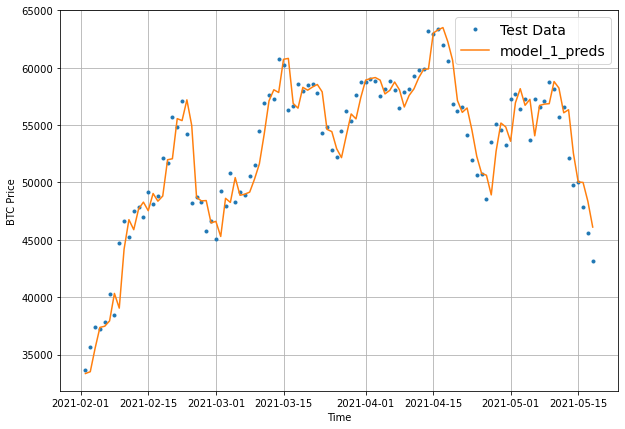

In [52]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [53]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [54]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


window setp: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]



(2757, 2757)

In [55]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [56]:

#import absl.logging
#absl.logging.set_verbosity(absl.logging.ERROR)



# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


In [57]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 611.9213


611.9213256835938

In [58]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 611.8959


611.8958740234375

In [59]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [60]:
tf.squeeze(test_labels).shape, model_2_preds.shape

(TensorShape([552]), TensorShape([552]))

In [61]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 611.8957,
 'mse': 1286140.2,
 'rmse': 1134.0812,
 'mape': 2.772315,
 'mase': 1.0695996}

In [62]:
model_1_results

{'mae': 566.4916,
 'mse': 1156180.2,
 'rmse': 1075.2582,
 'mape': 2.5512402,
 'mase': 0.9951688}

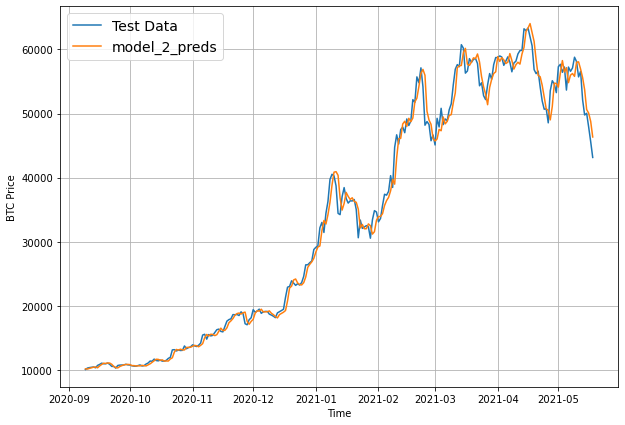

In [63]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

### Model 3: Dense (window = 30, horizon = 7)

In [64]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [65]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [66]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]



(2751, 2751)

In [67]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [68]:
def build_model_arq1(horizon,name):
    model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(horizon)
    ], name=name)
    return model
    

In [69]:
# build
model_3 = build_model_arq1(HORIZON,"model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 9s - loss: 4796.9307INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 37ms/step - loss: 2358.5637 - val_loss: 2722.6584
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 603.3015INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 32ms/step - loss: 543.0222 - val_loss: 2088.4802
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 387.9996INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 34ms/step - loss: 391.2978 - val_loss: 1733.4613
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 371.1879INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 38ms/step - loss: 338.2578 - val_loss: 1680.8378
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 279.7176INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 30ms/step - loss: 316.6022 - val_loss: 1679.8044
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 304.9167 - val_loss: 1706.2047
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 310.1865INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 36ms/step - loss: 294.0769 - val_loss: 1602.0447
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 320.7500INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 32ms/step - loss: 289.1663 - val_loss: 1527.2312
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 285.3182 - val_loss: 1558.3542
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 223.8359INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 45ms/step - loss: 287.2700 - val_loss: 1487.9384
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 281.5553 - val_loss: 1535.4055
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 274.2399 - val_loss: 1598.5969
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 274.8499 - val_loss: 1596.1171
Epoch 14/100
18/18 [==============================] - 0s 6ms/step - loss: 274.5457 - val_loss: 1558.7300
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 268.0229 - val_loss: 1559.0216
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 285.7288INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 42ms/step - loss: 268.7547 - val_loss: 1471.9022
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 288.7256INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 36ms/step - loss: 263.7366 - val_loss: 1433.9224
Epoch 18/100
18/18 [==============================] - 0s 4ms/step - loss: 265.6909 - val_loss: 1539.4189
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 269.5738 - val_loss: 1596.2108
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 356.6957INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 29ms/step - loss: 262.4214 - val_loss: 1395.1627
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 259.8731 - val_loss: 1421.4952
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 259.7044 - val_loss: 1682.9374
Epoch 23/100
18/18 [==============================] - 0s 4ms/step - loss: 256.5538 - val_loss: 1460.8082
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 256.1835 - val_loss: 1471.6692
Epoch 25/100
18/18 [==============================] - 0s 4ms/step - loss: 259.9165 - val_loss: 1407.8960
Epoch 26/100
18/18 [==============================] - 0s 3ms/step - loss: 255.0193 - val_loss: 1501.3691
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 252.5407 - val_loss: 1396.2291
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 289.8478INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 32ms/step - loss: 252.8252 - val_loss: 1373.9863
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 248.8154 - val_loss: 1452.4786
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 227.9075INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 39ms/step - loss: 249.3242 - val_loss: 1371.7609
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 249.3368 - val_loss: 1501.9330
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 253.1207 - val_loss: 1390.2238
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 247.0415 - val_loss: 1410.5654
Epoch 34/100
18/18 [==============================] - 0s 3ms/step - loss: 248.0771 - val_loss: 1506.9711
Epoch 35/100
18/18 [==============================] - 0s 4ms/step - loss: 251.1733 - val_loss: 1397.6379
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 251.8046 - val_loss: 1394.4067
Epoch 37/100
18/18 [==============================] - 0s 4ms/step - loss: 248.7565 - val_loss: 1604.2603
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 243.6777INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 37ms/step - loss: 256.7068 - val_loss: 1345.0463
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 246.5750 - val_loss: 1394.3406
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 213.2481INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 31ms/step - loss: 245.1368 - val_loss: 1327.7218
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 241.9485 - val_loss: 1506.3231
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 245.3012 - val_loss: 1578.1636
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 245.1973 - val_loss: 1471.2162
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 277.2283INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 35ms/step - loss: 241.8114 - val_loss: 1318.8099
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 239.9371 - val_loss: 1482.3165
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 193.8415INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 37ms/step - loss: 244.3600 - val_loss: 1309.5460
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 240.4159 - val_loss: 1683.0344
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 293.3132INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 35ms/step - loss: 253.3191 - val_loss: 1287.2734
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 249.0910 - val_loss: 1378.6602
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 235.8239 - val_loss: 1306.9358
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 237.2303 - val_loss: 1343.7017
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 215.3183INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 31ms/step - loss: 243.8608 - val_loss: 1281.9305
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 241.4024 - val_loss: 1291.2048
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 239.1672 - val_loss: 1688.6527
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 248.4107 - val_loss: 1397.2832
Epoch 56/100
18/18 [==============================] - 0s 3ms/step - loss: 234.1648 - val_loss: 1309.4094
Epoch 57/100
18/18 [==============================] - 0s 3ms/step - loss: 242.4454 - val_loss: 1303.3358
Epoch 58/100
18/18 [==============================] - 0s 3ms/step - loss: 238.7988 - val_loss: 1295.0713
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 243.4668INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 30ms/step - loss: 234.8242 - val_loss: 1268.0537
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 233.1057 - val_loss: 1319.9288
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 236.1442 - val_loss: 1312.3772
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 236.5533 - val_loss: 1447.6211
Epoch 63/100
 1/18 [>.............................] - ETA: 0s - loss: 328.2529INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 33ms/step - loss: 235.1092 - val_loss: 1266.4091
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 234.3279 - val_loss: 1288.3047
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 234.0418 - val_loss: 1399.7507
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 233.4879 - val_loss: 1345.8378
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 229.6892 - val_loss: 1309.5269
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 228.3387 - val_loss: 1567.0100
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 242.3256 - val_loss: 1445.7439
Epoch 70/100
18/18 [==============================] - 0s 3ms/step - loss: 240.8883 - val_loss: 1298.2518
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 232.2995 - val_loss: 1316.7817
Epoch 72/100
18/18 [==============================] - 0s 4ms/step -

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 32ms/step - loss: 230.4495 - val_loss: 1258.8351
Epoch 78/100
18/18 [==============================] - 0s 3ms/step - loss: 241.6843 - val_loss: 1292.1221
Epoch 79/100
18/18 [==============================] - 0s 3ms/step - loss: 236.4982 - val_loss: 1286.3423
Epoch 80/100
18/18 [==============================] - 0s 3ms/step - loss: 231.2304 - val_loss: 1444.5836
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 241.3017 - val_loss: 1399.9613
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 250.1482 - val_loss: 1324.8563
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 232.6076 - val_loss: 1323.7327
Epoch 84/100
 1/18 [>.............................] - ETA: 0s - loss: 259.8934INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 1s 34ms/step - loss: 233.8945 - val_loss: 1230.8625
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 230.7883 - val_loss: 1287.1594
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 230.0523 - val_loss: 1275.4701
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 233.3768 - val_loss: 1324.2501
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 230.0149 - val_loss: 1414.5349
Epoch 89/100
18/18 [==============================] - 0s 3ms/step - loss: 233.6198 - val_loss: 1360.0621
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 226.8472 - val_loss: 1385.9860
Epoch 91/100
18/18 [==============================] - 0s 3ms/step - loss: 235.8566 - val_loss: 1258.7107
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 226.0237 - val_loss: 1363.7109
Epoch 93/100
18/18 [==============================] - 0s 5ms/step -

In [70]:
# Evaluate the model on the test data

# va a ser mayor xq aotra el horizonte ya no es 1, sino que mucho m[as
# predceinos mucho m[as alla en el futuro]

model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1274.2372


1274.2371826171875

In [71]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1230.8625


1230.862548828125

In [72]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9218.217, 9274.094, 9425.418, 9547.792, 9498.682, 9678.943,
        9841.562],
       [8988.671, 8870.111, 8994.037, 9325.057, 9207.859, 9310.74 ,
        9414.588],
       [8907.208, 9001.166, 8970.605, 9313.51 , 9117.756, 9265.648,
        9148.205],
       [8846.204, 9254.843, 9172.355, 9252.384, 9111.721, 9218.198,
        9077.106],
       [8553.452, 8917.542, 8979.642, 8892.395, 8875.106, 8795.675,
        8894.591]], dtype=float32)>

In [73]:
model_2_results

{'mae': 611.8957,
 'mse': 1286140.2,
 'rmse': 1134.0812,
 'mape': 2.772315,
 'mase': 1.0695996}

In [74]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [75]:
# Evaluate model_3 results (these are going multi-dimensional because we're trying to predict more than one timestep at a time)
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  704.6003  ,   467.77484 ,   448.86383 ,   506.6642  ,
          348.97836 ,   412.78537 ,   550.93414 ,   660.7873  ,
          689.6855  ,   789.4385  ,   910.4215  ,   767.3428  ,
          734.2059  ,   876.30914 ,   711.27747 ,   281.93744 ,
          188.47789 ,   181.2198  ,   155.58238 ,   236.69685 ,
          205.75293 ,   195.22803 ,   329.68695 ,   319.88016 ,
          199.15213 ,   179.81111 ,   135.46045 ,   154.7267  ,
          182.44148 ,   248.29785 ,   323.643   ,   434.0122  ,
          408.84082 ,   422.10757 ,   270.6626  ,   291.3303  ,
          342.83713 ,   234.9264  ,   239.78635 ,   192.28342 ,
          369.99756 ,    75.928505,    80.55538 ,    83.56376 ,
           91.80036 ,    99.998955,    93.77281 ,   169.5198  ,
           97.92167 ,   174.87096 ,   103.089775,   172.07143 ,
          268.74594 ,   149.45459 ,   185.46178 ,   299.99722 ,
          458.81815 ,   453.3515  ,   543.7744  ,   580.3996  ,
          344.44608 ,   204.16316

In [76]:
model_3_preds.shape # el 7 es xq el horizonte es 7

TensorShape([551, 7])

### Make our evaluation function work for larger horizons

In [77]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1230.8625


1230.862548828125

In [78]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1230.8624

In [79]:
model_2_results["mae"].ndim

0

In [80]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [81]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1230.8624,
 'mse': 5476643.0,
 'rmse': 1416.705,
 'mape': 5.5381675,
 'mase': 2.1902506}

In [82]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9218.217, 9274.094, 9425.418, 9547.792, 9498.682, 9678.943,
        9841.562],
       [8988.671, 8870.111, 8994.037, 9325.057, 9207.859, 9310.74 ,
        9414.588],
       [8907.208, 9001.166, 8970.605, 9313.51 , 9117.756, 9265.648,
        9148.205],
       [8846.204, 9254.843, 9172.355, 9252.384, 9111.721, 9218.198,
        9077.106],
       [8553.452, 8917.542, 8979.642, 8892.395, 8875.106, 8795.675,
        8894.591]], dtype=float32)>

In [83]:
test_labels[:]

array([[ 8794.35864452,  8798.04205463,  9081.18687849, ...,
         8760.89271814,  8749.52059102,  8656.97092235],
       [ 8798.04205463,  9081.18687849,  8711.53433917, ...,
         8749.52059102,  8656.97092235,  8500.64355816],
       [ 9081.18687849,  8711.53433917,  8760.89271814, ...,
         8656.97092235,  8500.64355816,  8469.2608989 ],
       ...,
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361],
       [56573.5554719 , 52147.82118698, 49764.1320816 , ...,
        47885.62525472, 45604.61575361, 43144.47129086]])

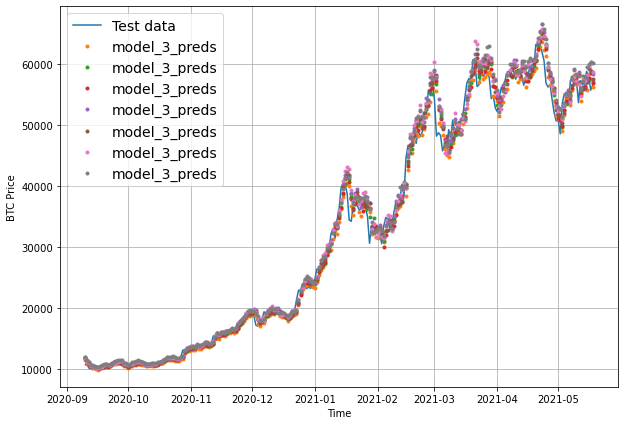

In [84]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

In [85]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9218.217, 9274.094, 9425.418, 9547.792, 9498.682, 9678.943,
       9841.562], dtype=float32)>

In [86]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9497.815>

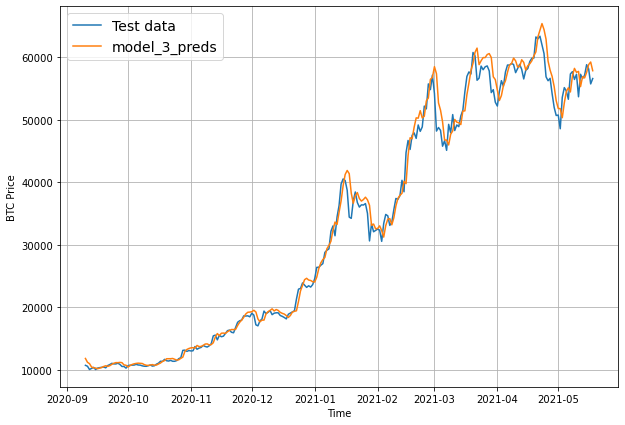

In [87]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 start=offset,
                 format="-", 
                 label="model_3_preds")

## Which of our models is performing the best so far? 

So we've trained a few models, now let's compare them and see how they've gone... 

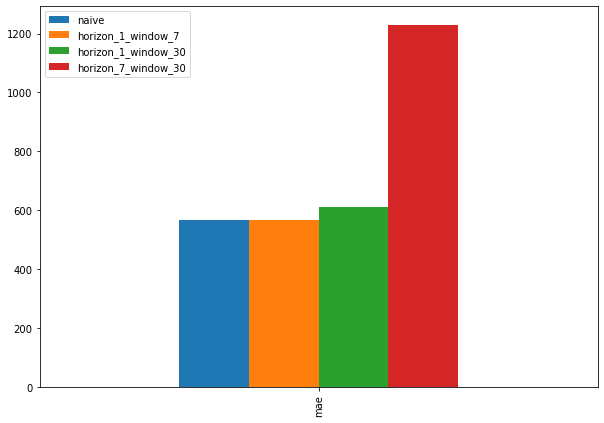

In [88]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

recuerdo que mientras menor sea el error, mejor

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424).

### Model 4: Conv1D

In [89]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [90]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[0 1 2 3 4 5 6 7]]



(2780, 2780)

In [91]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [112]:
type(train_windows)

numpy.ndarray

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

En el contexto de un problema de series temporales con un horizonte (horizon) de 1 y un tamaño de ventana (window_size) de 7, la forma del tensor de entrada (input_shape) sería crucial para determinar el tamaño de input_dim. La forma general del tensor sería (batch_size, window_size, input_dim).

Dado que window_size es 7, el modelo consideraría secuencias de 7 pasos temporales como entrada en cada lote. Sin embargo, el horizonte de predicción (horizon) es 1, lo que significa que el modelo está diseñado para predecir el siguiente paso temporal en cada secuencia.

Por lo tanto, el tamaño de input_dim debe ser el número de características o variables en cada paso temporal. Si tus secuencias tienen una única característica en cada paso de tiempo (por ejemplo, univariadas), entonces input_dim sería 1. Si tienes múltiples características en cada paso de tiempo (por ejemplo, series temporales multivariadas), entonces input_dim sería el número total de características.

Entonces, en resumen, para un problema de series temporales con un horizonte de 1 y una ventana de 7, y si tus datos tienen una sola característica en cada paso de tiempo, input_dim debería ser 1. Si tienes múltiples características en cada paso de tiempo, input_dim sería el número total de características.

In [94]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )


print(type(train_windows))


print(type(full_windows))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [102]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [103]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`


# queremos que el modelo prediga un día con una 1 semana de datos, por eso input_dim=1?????


In [104]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDIW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [105]:

#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

# nota expand dims

aux = tf.constant([1,2,3])

print(aux.shape)


aux2 = tf.expand_dims(aux,axis=1)


print(aux2.shape)


print(aux2)


(3,)
(3, 1)
tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32)


In [110]:
def build_model_4(x,horizon):
    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.Dense(horizon)
    ],name="model_4_conv1D")
    return model
    
    
model_4 = build_model_4(x,1)
    

In [109]:
x.shape

x




<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [111]:
# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 10s - loss: 3141.6750INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 59ms/step - loss: 1893.2012 - val_loss: 2331.5552
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 463.3788INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 326.7394 - val_loss: 1243.9503
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 279.3809INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 48ms/step - loss: 217.7117 - val_loss: 1077.3604
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 189.8077INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 41ms/step - loss: 195.7119 - val_loss: 1065.5713
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 148.4172INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 47ms/step - loss: 193.4745 - val_loss: 1051.3843
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 191.7095INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 42ms/step - loss: 187.0378 - val_loss: 1038.0187
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 196.0287INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 45ms/step - loss: 188.2746 - val_loss: 1023.8608
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 184.3979 - val_loss: 1117.1243
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 181.2023 - val_loss: 1116.8208
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 157.8344INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 177.7615 - val_loss: 984.7368
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 192.1094INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 54ms/step - loss: 175.2241 - val_loss: 962.3148
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 172.4491 - val_loss: 1005.9728
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 167.7597 - val_loss: 963.0754
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 127.8838INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 42ms/step - loss: 168.1973 - val_loss: 916.0045
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 149.1926INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 43ms/step - loss: 163.0080 - val_loss: 896.0354
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 161.9191 - val_loss: 933.4632
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 171.3168INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 46ms/step - loss: 156.6727 - val_loss: 864.1257
Epoch 18/100
18/18 [==============================] - 0s 4ms/step - loss: 154.7567 - val_loss: 940.5999
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 173.6271INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 43ms/step - loss: 151.7649 - val_loss: 832.0767
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 148.1825INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 42ms/step - loss: 149.2000 - val_loss: 815.7919
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 149.2626INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 144.6998 - val_loss: 799.6289
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 142.5295INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 43ms/step - loss: 144.4093 - val_loss: 796.2037
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 165.1508INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 51ms/step - loss: 143.2791 - val_loss: 787.3422
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 113.4990INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 41ms/step - loss: 140.0824 - val_loss: 772.4566
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 225.3281INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 58ms/step - loss: 136.7153 - val_loss: 756.4880
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 135.3302 - val_loss: 759.2542
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 130.4118INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 42ms/step - loss: 132.8486 - val_loss: 737.3356
Epoch 28/100
18/18 [==============================] - 0s 4ms/step - loss: 131.0216 - val_loss: 767.3968
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 126.6511INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 47ms/step - loss: 131.3711 - val_loss: 706.1605
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 122.6817INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 48ms/step - loss: 130.0195 - val_loss: 704.8116
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 119.5906INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 52ms/step - loss: 127.0892 - val_loss: 687.8005
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 98.7742INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 58ms/step - loss: 125.3865 - val_loss: 680.2656
Epoch 33/100
17/18 [===========================>..] - ETA: 0s - loss: 124.2038INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 64ms/step - loss: 123.3944 - val_loss: 671.1374
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 122.3604INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 55ms/step - loss: 124.2105 - val_loss: 667.3991
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 100.4235INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 64ms/step - loss: 123.1986 - val_loss: 659.8589
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 111.1478INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 57ms/step - loss: 123.1867 - val_loss: 653.4144
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 123.9586 - val_loss: 654.2724
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 131.5241INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 86ms/step - loss: 119.2466 - val_loss: 644.0566
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 129.4575 - val_loss: 648.3831
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 120.7599 - val_loss: 648.4722
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 118.3119 - val_loss: 712.2989
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 157.9198INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 69ms/step - loss: 119.2775 - val_loss: 629.6317
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 120.5515 - val_loss: 631.8087
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 117.2369 - val_loss: 655.5977
Epoch 45/100
18/18 [==============================] - 0s 7ms/step - loss: 116.8353 - val_loss: 644.2024
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 121.1180INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 70ms/step - loss: 115.9964 - val_loss: 617.1513
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 116.2692 - val_loss: 662.8503
Epoch 48/100
18/18 [==============================] - 0s 8ms/step - loss: 115.5704 - val_loss: 681.2225
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 115.7386 - val_loss: 654.2639
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 117.4613 - val_loss: 639.1277
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 121.9595INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 52ms/step - loss: 115.3986 - val_loss: 607.2855
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1884 - val_loss: 635.6846
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3728 - val_loss: 610.7027
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 92.4445INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 47ms/step - loss: 114.5476 - val_loss: 602.5858
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 106.3133INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 115.2015 - val_loss: 600.6545
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1392 - val_loss: 612.0691
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 114.7994 - val_loss: 613.1268
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 120.3175 - val_loss: 667.4609
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 121.5051 - val_loss: 651.7789
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 109.5660INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 54ms/step - loss: 114.9990 - val_loss: 590.7336
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 111.7407 - val_loss: 777.1558
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 132.9862INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 116.9590 - val_loss: 589.4990
Epoch 63/100
 1/18 [>.............................] - ETA: 0s - loss: 103.2771INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 46ms/step - loss: 116.2940 - val_loss: 587.4280
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 115.3019 - val_loss: 601.6379
Epoch 65/100
18/18 [==============================] - 0s 3ms/step - loss: 118.1606 - val_loss: 881.7059
Epoch 66/100
18/18 [==============================] - 0s 3ms/step - loss: 129.8375 - val_loss: 691.6509
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 115.5498 - val_loss: 594.3217
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 115.0482 - val_loss: 695.4881
Epoch 69/100
 1/18 [>.............................] - ETA: 0s - loss: 87.1229INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 112.5670 - val_loss: 582.1689
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2896 - val_loss: 615.0328
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 101.9112INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 57ms/step - loss: 112.3884 - val_loss: 580.6135
Epoch 72/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9354 - val_loss: 598.7009
Epoch 73/100
18/18 [==============================] - 0s 3ms/step - loss: 110.4574 - val_loss: 605.9053
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 120.4429INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 41ms/step - loss: 113.6130 - val_loss: 579.1168
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2034 - val_loss: 608.7224
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 114.0039 - val_loss: 579.8412
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 87.4329INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 45ms/step - loss: 109.5108 - val_loss: 576.4434
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 113.4396 - val_loss: 673.1917
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6009 - val_loss: 577.8238
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 108.4961 - val_loss: 597.0473
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 126.5488INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 42ms/step - loss: 111.9425 - val_loss: 575.8906
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 108.3103 - val_loss: 595.8070
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9929 - val_loss: 623.2590
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 111.0542 - val_loss: 657.7606
Epoch 85/100
 1/18 [>.............................] - ETA: 0s - loss: 104.2160INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 43ms/step - loss: 111.2921 - val_loss: 573.4902
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3302 - val_loss: 607.6401
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 112.4098 - val_loss: 584.1006
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 108.5329 - val_loss: 593.0817
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 93.0561INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 53ms/step - loss: 108.6977 - val_loss: 570.9698
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 108.8668 - val_loss: 571.3297
Epoch 91/100
 1/18 [>.............................] - ETA: 0s - loss: 151.2342INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 51ms/step - loss: 107.4284 - val_loss: 569.3690
Epoch 92/100
18/18 [==============================] - 0s 3ms/step - loss: 107.9682 - val_loss: 599.9670
Epoch 93/100
18/18 [==============================] - 0s 3ms/step - loss: 111.7942 - val_loss: 606.5600
Epoch 94/100
18/18 [==============================] - 0s 3ms/step - loss: 119.7725 - val_loss: 616.2564
Epoch 95/100
18/18 [==============================] - 0s 3ms/step - loss: 107.4694 - val_loss: 638.5856
Epoch 96/100
 1/18 [>.............................] - ETA: 0s - loss: 144.9512INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 49ms/step - loss: 112.1410 - val_loss: 568.3215
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9830 - val_loss: 589.7438
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7267 - val_loss: 629.5518
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3253 - val_loss: 568.5238
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3659 - val_loss: 577.9221


In [99]:
test_windows.shape

(556, 7)

In [100]:
train_windows.shape

(2224, 7)

In [101]:
x.shape

TensorShape([2, 2])

In [99]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [100]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


vemos que el tamaño de la salida de los modelos es diferente

In [101]:
# Evaluate model... 
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 626.4283


626.4283447265625

In [102]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 569.3861


569.3861083984375

In [103]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8904.229, 8815.779, 9030.463, 8787.074, 8767.69 , 8765.97 ,
       8697.225, 8544.581, 8490.385, 8538.065], dtype=float32)>

In [104]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.3861,
 'mse': 1176383.4,
 'rmse': 1084.612,
 'mape': 2.547315,
 'mase': 1.0002537}

### Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [105]:



def build_model_5(window_size):
    # Let's build an LSTM model with the Functional API
    inputs = layers.Input(shape=(window_size))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    # x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128, activation="relu")(x)
    # x = layers.Dense(32, activation="relu")(x)
    output = layers.Dense(HORIZON)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")
    return model


model_5 = build_model_5(WINDOW_SIZE)
    
    
# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2771.8750 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 185ms/step - loss: 2492.1213 - val_loss: 11380.9375
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 869.6261 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 220ms/step - loss: 814.6375 - val_loss: 1344.0483
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 270.8989 - val_loss: 1473.9708
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 212.4908INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 185ms/step - loss: 207.9924 - val_loss: 1082.2905
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 191.0554 - val_loss: 1110.7040
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 190.2551 - val_loss: 1107.7002
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 183.2077INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 198ms/step - loss: 188.4085 - val_loss: 1071.6873
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 186.6085 - val_loss: 1085.1687
Epoch 9/100
10/18 [===============>..............] - ETA: 0s - loss: 186.5679INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 209ms/step - loss: 186.0627 - val_loss: 1056.7777
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 183.3478 - val_loss: 1063.8070
Epoch 11/100
11/18 [=================>............] - ETA: 0s - loss: 187.3701INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 208ms/step - loss: 181.7432 - val_loss: 1040.3685
Epoch 12/100
10/18 [===============>..............] - ETA: 0s - loss: 174.8225INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 160ms/step - loss: 179.9910 - val_loss: 1040.2660
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 179.1389 - val_loss: 1047.9839
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 167.6738INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 152ms/step - loss: 176.3659 - val_loss: 1005.0509
Epoch 15/100
14/18 [======================>.......] - ETA: 0s - loss: 170.5997INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 157ms/step - loss: 173.5744 - val_loss: 978.1402
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 170.9974INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 200ms/step - loss: 171.6381 - val_loss: 973.7986
Epoch 17/100
17/18 [===========================>..] - ETA: 0s - loss: 170.3477INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 189ms/step - loss: 169.7089 - val_loss: 971.8643
Epoch 18/100
18/18 [==============================] - 0s 9ms/step - loss: 168.0691 - val_loss: 978.5065
Epoch 19/100
 9/18 [==============>...............] - ETA: 0s - loss: 172.1829INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 164ms/step - loss: 167.1578 - val_loss: 946.0462
Epoch 20/100
15/18 [========================>.....] - ETA: 0s - loss: 164.5995INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 199ms/step - loss: 163.3850 - val_loss: 923.9392
Epoch 21/100
10/18 [===============>..............] - ETA: 0s - loss: 163.5437INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 217ms/step - loss: 163.8760 - val_loss: 907.7911
Epoch 22/100
18/18 [==============================] - 0s 9ms/step - loss: 159.5064 - val_loss: 925.2618
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 158.1495INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 215ms/step - loss: 157.6033 - val_loss: 875.0153
Epoch 24/100
18/18 [==============================] - 0s 13ms/step - loss: 155.1444 - val_loss: 895.3972
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 156.9877INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 202ms/step - loss: 153.9531 - val_loss: 850.6573
Epoch 26/100
18/18 [==============================] - 0s 10ms/step - loss: 154.3978 - val_loss: 902.4018
Epoch 27/100
14/18 [======================>.......] - ETA: 0s - loss: 152.8964INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 181ms/step - loss: 149.8121 - val_loss: 828.6390
Epoch 28/100
18/18 [==============================] - 0s 11ms/step - loss: 148.8750 - val_loss: 831.8282
Epoch 29/100
18/18 [==============================] - 0s 10ms/step - loss: 146.9802 - val_loss: 855.2210
Epoch 30/100
10/18 [===============>..............] - ETA: 0s - loss: 144.3946INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 184ms/step - loss: 145.5692 - val_loss: 797.7015
Epoch 31/100
18/18 [==============================] - 0s 14ms/step - loss: 142.6296 - val_loss: 798.5143
Epoch 32/100
18/18 [==============================] - 0s 9ms/step - loss: 147.5764 - val_loss: 856.8034
Epoch 33/100
10/18 [===============>..............] - ETA: 0s - loss: 140.7608INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 165ms/step - loss: 143.3534 - val_loss: 786.4682
Epoch 34/100
11/18 [=================>............] - ETA: 0s - loss: 140.6786INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 175ms/step - loss: 142.3880 - val_loss: 767.5748
Epoch 35/100
18/18 [==============================] - 0s 11ms/step - loss: 137.6964 - val_loss: 847.9840
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 140.5878INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 169ms/step - loss: 139.8462 - val_loss: 755.7513
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 136.1428INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 197ms/step - loss: 137.0075 - val_loss: 751.6027
Epoch 38/100
18/18 [==============================] - 0s 9ms/step - loss: 134.3849 - val_loss: 819.1562
Epoch 39/100
18/18 [==============================] - ETA: 0s - loss: 134.7364INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 205ms/step - loss: 134.7364 - val_loss: 733.0044
Epoch 40/100
18/18 [==============================] - 0s 11ms/step - loss: 133.0970 - val_loss: 740.4422
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 132.5680INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 267ms/step - loss: 132.9297 - val_loss: 717.9495
Epoch 42/100
18/18 [==============================] - 0s 12ms/step - loss: 132.3515 - val_loss: 719.9689
Epoch 43/100
17/18 [===========================>..] - ETA: 0s - loss: 128.0880INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 221ms/step - loss: 128.5059 - val_loss: 706.2144
Epoch 44/100
18/18 [==============================] - 0s 12ms/step - loss: 127.4703 - val_loss: 718.8307
Epoch 45/100
18/18 [==============================] - 0s 11ms/step - loss: 128.1143 - val_loss: 710.2353
Epoch 46/100
16/18 [=========================>....] - ETA: 0s - loss: 128.3368INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 260ms/step - loss: 129.4565 - val_loss: 704.0504
Epoch 47/100
18/18 [==============================] - 0s 11ms/step - loss: 128.3440 - val_loss: 742.8249
Epoch 48/100
14/18 [======================>.......] - ETA: 0s - loss: 135.2254INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 271ms/step - loss: 132.9095 - val_loss: 679.5127
Epoch 49/100
14/18 [======================>.......] - ETA: 0s - loss: 131.3946INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 239ms/step - loss: 124.7181 - val_loss: 677.2939
Epoch 50/100
18/18 [==============================] - ETA: 0s - loss: 123.7431INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 191ms/step - loss: 123.7431 - val_loss: 671.1727
Epoch 51/100
18/18 [==============================] - 0s 11ms/step - loss: 124.7589 - val_loss: 676.4893
Epoch 52/100
18/18 [==============================] - 0s 12ms/step - loss: 126.7155 - val_loss: 692.4171
Epoch 53/100
17/18 [===========================>..] - ETA: 0s - loss: 123.4075INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 225ms/step - loss: 123.8072 - val_loss: 659.3525
Epoch 54/100
18/18 [==============================] - 0s 10ms/step - loss: 121.7215 - val_loss: 660.0581
Epoch 55/100
18/18 [==============================] - 0s 9ms/step - loss: 121.4591 - val_loss: 678.0097
Epoch 56/100
10/18 [===============>..............] - ETA: 0s - loss: 122.6521INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 196ms/step - loss: 120.6859 - val_loss: 655.0613
Epoch 57/100
10/18 [===============>..............] - ETA: 0s - loss: 123.8605INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 182ms/step - loss: 120.7440 - val_loss: 647.2791
Epoch 58/100
18/18 [==============================] - ETA: 0s - loss: 120.2823INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 186ms/step - loss: 120.2823 - val_loss: 647.1005
Epoch 59/100
18/18 [==============================] - ETA: 0s - loss: 120.6264INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 198ms/step - loss: 120.6264 - val_loss: 642.1656
Epoch 60/100
18/18 [==============================] - ETA: 0s - loss: 118.6381INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 197ms/step - loss: 118.6381 - val_loss: 639.1556
Epoch 61/100
18/18 [==============================] - 0s 9ms/step - loss: 119.6847 - val_loss: 684.0563
Epoch 62/100
18/18 [==============================] - ETA: 0s - loss: 118.1934INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 179ms/step - loss: 118.1934 - val_loss: 634.7225
Epoch 63/100
18/18 [==============================] - 0s 9ms/step - loss: 118.1885 - val_loss: 652.2281
Epoch 64/100
10/18 [===============>..............] - ETA: 0s - loss: 122.1779INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 190ms/step - loss: 118.2182 - val_loss: 629.7120
Epoch 65/100
18/18 [==============================] - 0s 10ms/step - loss: 119.7196 - val_loss: 655.4595
Epoch 66/100
10/18 [===============>..............] - ETA: 0s - loss: 120.4156INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 175ms/step - loss: 119.4571 - val_loss: 627.2460
Epoch 67/100
10/18 [===============>..............] - ETA: 0s - loss: 117.5204INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 212ms/step - loss: 116.8863 - val_loss: 624.5966
Epoch 68/100
18/18 [==============================] - 0s 12ms/step - loss: 116.3505 - val_loss: 634.2553
Epoch 69/100
16/18 [=========================>....] - ETA: 0s - loss: 120.6006INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 215ms/step - loss: 118.7303 - val_loss: 620.7311
Epoch 70/100
18/18 [==============================] - 0s 12ms/step - loss: 118.8814 - val_loss: 661.4951
Epoch 71/100
18/18 [==============================] - 0s 10ms/step - loss: 119.7351 - val_loss: 669.7579
Epoch 72/100
18/18 [==============================] - 0s 11ms/step - loss: 121.4048 - val_loss: 624.7035
Epoch 73/100
16/18 [=========================>....] - ETA: 0s - loss: 115.5247INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 201ms/step - loss: 116.3418 - val_loss: 615.2300
Epoch 74/100
18/18 [==============================] - 0s 13ms/step - loss: 115.8109 - val_loss: 631.0511
Epoch 75/100
18/18 [==============================] - 0s 11ms/step - loss: 117.3702 - val_loss: 615.2692
Epoch 76/100
15/18 [========================>.....] - ETA: 0s - loss: 121.0640INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 210ms/step - loss: 116.6331 - val_loss: 611.7878
Epoch 77/100
18/18 [==============================] - 0s 11ms/step - loss: 115.1139 - val_loss: 666.4857
Epoch 78/100
18/18 [==============================] - 0s 11ms/step - loss: 116.3870 - val_loss: 620.2044
Epoch 79/100
18/18 [==============================] - 0s 10ms/step - loss: 115.1280 - val_loss: 615.9022
Epoch 80/100
18/18 [==============================] - 0s 9ms/step - loss: 113.5007 - val_loss: 631.0450
Epoch 81/100
10/18 [===============>..............] - ETA: 0s - loss: 107.6715INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 189ms/step - loss: 115.0434 - val_loss: 604.9859
Epoch 82/100
18/18 [==============================] - 0s 10ms/step - loss: 113.7832 - val_loss: 619.9486
Epoch 83/100
18/18 [==============================] - 0s 13ms/step - loss: 113.6869 - val_loss: 612.0959
Epoch 84/100
18/18 [==============================] - ETA: 0s - loss: 113.3500INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 191ms/step - loss: 113.3500 - val_loss: 602.6153
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 114.2071 - val_loss: 608.7127
Epoch 86/100
18/18 [==============================] - ETA: 0s - loss: 112.3552INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 202ms/step - loss: 112.3552 - val_loss: 601.1647
Epoch 87/100
16/18 [=========================>....] - ETA: 0s - loss: 111.3686INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 203ms/step - loss: 112.2792 - val_loss: 598.3995
Epoch 88/100
18/18 [==============================] - 0s 12ms/step - loss: 112.6305 - val_loss: 598.9304
Epoch 89/100
16/18 [=========================>....] - ETA: 0s - loss: 113.0228INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 192ms/step - loss: 112.7201 - val_loss: 596.7120
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 113.5339 - val_loss: 624.3146
Epoch 91/100
18/18 [==============================] - 0s 13ms/step - loss: 117.1082 - val_loss: 597.9169
Epoch 92/100
18/18 [==============================] - 0s 9ms/step - loss: 111.7367 - val_loss: 601.3628
Epoch 93/100
18/18 [==============================] - 0s 10ms/step - loss: 111.9096 - val_loss: 606.1633
Epoch 94/100
18/18 [==============================] - 0s 11ms/step - loss: 113.5698 - val_loss: 617.5853
Epoch 95/100
18/18 [==============================] - 0s 12ms/step - loss: 113.5962 - val_loss: 626.6831
Epoch 96/100
18/18 [==============================] - 0s 12ms/step - loss: 114.1664 - val_loss: 654.5596
Epoch 97/100
18/18 [==============================] - 0s 14ms/step - loss: 114.1939 - val_loss: 604.5869
Epoch 98/100
18/18 [==============================] - 0s 13ms/step -

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 231ms/step - loss: 111.5761 - val_loss: 586.8714


In [106]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 586.8714


586.8713989257812

In [107]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8949.035, 8833.007, 8982.96 , 8812.621, 8758.619], dtype=float32)>

In [108]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 586.87146,
 'mse': 1244928.8,
 'rmse': 1115.7638,
 'mape': 2.6589785,
 'mase': 1.0309706}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [109]:
# Let's make a multivariate time series 
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [110]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [111]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [112]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [113]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


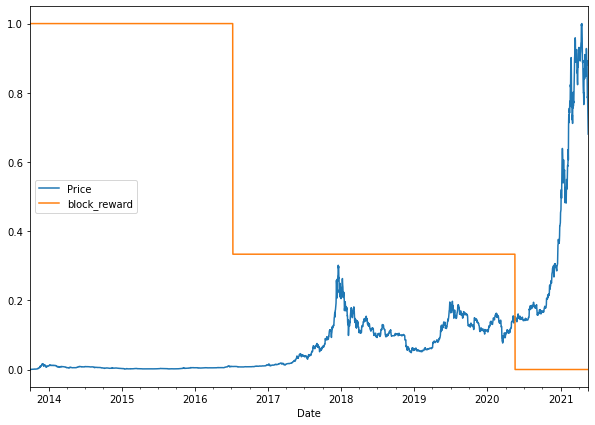

In [114]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [115]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [116]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


para los valores price+1 a price+7 el horizonte es price

In [117]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [118]:


# vamos a quitar lo que no tiene valores (los NaN)



# price será la etiqueta


# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [119]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [120]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [121]:


def build_model_6(horizon,name):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(horizon)
    ],name=name)
    return model
    
    
model_6 = build_model_6(HORIZON,"model_6_dense_multivariate")    


# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 19s - loss: 6243.7524INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 2s 65ms/step - loss: 3943.9788 - val_loss: 12693.5381
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 1839.3047INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 53ms/step - loss: 785.8681 - val_loss: 2958.6719
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 292.7216INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 50ms/step - loss: 290.9261 - val_loss: 1163.4463
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 230.6688 - val_loss: 1194.9442
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 204.2312INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 63ms/step - loss: 208.9740 - val_loss: 1149.2571
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 164.1349INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 52ms/step - loss: 202.8829 - val_loss: 1115.0160
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 200.6830 - val_loss: 1137.7975
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 196.8466 - val_loss: 1161.6475
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 192.2969INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 51ms/step - loss: 192.2969 - val_loss: 1084.0670
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 158.3503INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 51ms/step - loss: 188.6779 - val_loss: 1045.5457
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 185.4630INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 48ms/step - loss: 185.2178 - val_loss: 1019.4789
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 180.0257INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 48ms/step - loss: 180.2435 - val_loss: 987.9876
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 189.1039INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 176.2716 - val_loss: 971.1443
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 171.0614 - val_loss: 974.3292
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 164.6326INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 59ms/step - loss: 167.0353 - val_loss: 953.2974
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 145.1674INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 53ms/step - loss: 166.0386 - val_loss: 934.5031
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 182.7289INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 52ms/step - loss: 160.3086 - val_loss: 879.4319
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 126.6203INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 161.7058 - val_loss: 866.2958
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 161.9588INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 158.4962 - val_loss: 835.2407
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 151.1278 - val_loss: 897.5195
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 143.2294INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 52ms/step - loss: 155.1659 - val_loss: 832.2866
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 137.5883INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 47ms/step - loss: 152.6628 - val_loss: 797.2046
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 149.8044INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 66ms/step - loss: 147.5930 - val_loss: 783.2294
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 142.8632 - val_loss: 892.6358
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 145.8819 - val_loss: 913.6349
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 151.7719 - val_loss: 874.9131
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 146.2891 - val_loss: 807.5184
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 132.1131INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 53ms/step - loss: 144.4754 - val_loss: 773.0154
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 126.7990INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 136.4737 - val_loss: 744.7530
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 135.5963 - val_loss: 811.7297
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 157.6399INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 51ms/step - loss: 135.5758 - val_loss: 731.7670
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 148.8683INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 138.7401 - val_loss: 711.3907
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 149.6213INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 52ms/step - loss: 135.4121 - val_loss: 708.8054
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 141.0319 - val_loss: 870.9530
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 133.0941 - val_loss: 741.5169
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 131.7275 - val_loss: 744.5911
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 146.2804INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 62ms/step - loss: 129.3163 - val_loss: 682.4630
Epoch 38/100
18/18 [==============================] - 0s 7ms/step - loss: 128.9491 - val_loss: 709.1545
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 128.0899 - val_loss: 694.3317
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 112.4483INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 59ms/step - loss: 127.9257 - val_loss: 667.1556
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 125.7465 - val_loss: 670.1607
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 130.3451 - val_loss: 735.4476
Epoch 43/100
 1/18 [>.............................] - ETA: 0s - loss: 170.3060INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 53ms/step - loss: 126.6306 - val_loss: 663.1521
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 135.1648 - val_loss: 790.6045
Epoch 45/100
18/18 [==============================] - 0s 9ms/step - loss: 133.4770 - val_loss: 680.2723
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 174.9366INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 55ms/step - loss: 123.1278 - val_loss: 652.4067
Epoch 47/100
 1/18 [>.............................] - ETA: 0s - loss: 104.0947INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 122.6419 - val_loss: 651.2245
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 122.2498 - val_loss: 683.5479
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 124.7456 - val_loss: 703.7145
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 159.6926INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 49ms/step - loss: 121.5233 - val_loss: 646.4880
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 120.7971 - val_loss: 652.0563
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 103.8500INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 62ms/step - loss: 124.3896 - val_loss: 636.7701
Epoch 53/100
18/18 [==============================] - 0s 8ms/step - loss: 118.7843 - val_loss: 639.9907
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 119.2477 - val_loss: 642.2787
Epoch 55/100
18/18 [==============================] - ETA: 0s - loss: 119.6175INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 58ms/step - loss: 119.6175 - val_loss: 626.2075
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 122.2667 - val_loss: 654.2428
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 134.7538 - val_loss: 708.6825
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 123.1058 - val_loss: 629.0997
Epoch 59/100
18/18 [==============================] - 0s 8ms/step - loss: 118.0756 - val_loss: 643.3911
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 118.8274 - val_loss: 658.1125
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 120.9691 - val_loss: 664.3981
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 120.0770 - val_loss: 663.0248
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 122.8660 - val_loss: 728.7575
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 115.51

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 47ms/step - loss: 116.1713 - val_loss: 618.3207
Epoch 65/100
18/18 [==============================] - ETA: 0s - loss: 114.8720INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 47ms/step - loss: 114.8720 - val_loss: 608.1602
Epoch 66/100
16/18 [=========================>....] - ETA: 0s - loss: 115.6755INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 54ms/step - loss: 115.9900 - val_loss: 607.3375
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 121.6165 - val_loss: 610.7783
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 117.7423 - val_loss: 649.3363
Epoch 69/100
 1/18 [>.............................] - ETA: 0s - loss: 121.7388INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 54ms/step - loss: 118.1868 - val_loss: 601.5110
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 109.3532INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 66ms/step - loss: 116.3657 - val_loss: 599.0956
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 113.5178 - val_loss: 607.5808
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9934 - val_loss: 640.5864
Epoch 73/100
18/18 [==============================] - 0s 8ms/step - loss: 113.6998 - val_loss: 605.9810
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 115.9591 - val_loss: 642.7305
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 82.3531INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 49ms/step - loss: 112.6292 - val_loss: 592.0439
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 114.1816 - val_loss: 601.0406
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 113.2187 - val_loss: 605.1415
Epoch 78/100
18/18 [==============================] - 0s 8ms/step - loss: 113.1429 - val_loss: 665.7491
Epoch 79/100
 1/18 [>.............................] - ETA: 0s - loss: 182.1275INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 57ms/step - loss: 118.3917 - val_loss: 588.1176
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 110.3215 - val_loss: 608.8462
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 92.6101INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 49ms/step - loss: 114.0489 - val_loss: 587.3984
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 121.5214 - val_loss: 588.4211
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 112.5206 - val_loss: 589.4829
Epoch 84/100
16/18 [=========================>....] - ETA: 0s - loss: 113.0356INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 47ms/step - loss: 110.7785 - val_loss: 584.5302
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0450 - val_loss: 584.7208
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7956 - val_loss: 648.3129
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 121.3757INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 51ms/step - loss: 112.2380 - val_loss: 584.4542
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 114.0517 - val_loss: 618.0541
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 113.8045 - val_loss: 585.5461
Epoch 90/100
 1/18 [>.............................] - ETA: 0s - loss: 104.1313INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 49ms/step - loss: 109.0339 - val_loss: 580.8087
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 117.6928 - val_loss: 799.7974
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 122.9041 - val_loss: 595.0510
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 119.0056 - val_loss: 604.9813
Epoch 94/100
12/18 [===================>..........] - ETA: 0s - loss: 114.5797INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 60ms/step - loss: 110.8989 - val_loss: 580.4505
Epoch 95/100
18/18 [==============================] - 0s 7ms/step - loss: 109.4876 - val_loss: 625.2800
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.8824 - val_loss: 588.5161
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.1461 - val_loss: 633.8590
Epoch 98/100
18/18 [==============================] - ETA: 0s - loss: 113.0869INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 62ms/step - loss: 113.0869 - val_loss: 575.7573
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 109.2296 - val_loss: 586.3192
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9809 - val_loss: 613.2690


In [122]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 613.2690


613.2689819335938

In [123]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 575.7573


575.7572631835938

In [124]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8905.99 , 8766.637, 9003.392, 8815.432, 8742.087, 8755.313,
       8707.497, 8506.081, 8489.896, 8517.497], dtype=float32)>

In [125]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 575.75745,
 'mse': 1194360.4,
 'rmse': 1092.8679,
 'mape': 2.5715077,
 'mase': 1.0114464}

In [126]:
model_1_results

{'mae': 575.49493,
 'mse': 1188238.5,
 'rmse': 1090.0635,
 'mape': 2.5827935,
 'mase': 1.0109853}

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: N-BEATS algorithm


---> volvemos a univariate


Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture 
* Potentially get state of the art results on our problem 

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models


diagrama de la arquitectura

Comenzaremos por implementar el bloque siguiente:



<img src='images/block_layer.png'></img>




In [127]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
          x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and the forecast from theta
        
        
        #print('theta',theta,'\n')
        #print('backcast',theta[:, :self.input_size],'\n')
        
        # usa backcast para predecir forecast ---> chequear!!
        
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [128]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [129]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [130]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}\n")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.26155978 -0.2339958   0.058945   -0.07865025  0.05858079 -0.7011537
  0.5442393 ]

Forecast: 0.3790445923805237


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance 

In [131]:
HORIZON = 1
WINDOW_SIZE = 7 

In [132]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [133]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [134]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [135]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf 

In [136]:
# Values from N-BEATS paper
N_EPOCHS = 100 #5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet

In [137]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks: 
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance) 

<img src='images/N-beatss.png'/>

In [138]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, 
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=20, #N_EPOCHS
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)]
           
           )



Epoch 1/50
3/3 [==============================] - 54s 3s/step - loss: 43923.2031 - val_loss: 18551.8242 - lr: 0.0010
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 2740.6748 - val_loss: 1200.0646 - lr: 0.0010
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 1176.1493 - val_loss: 6046.8965 - lr: 0.0010
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 1600.7063 - val_loss: 4685.3438 - lr: 0.0010
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 775.2510 - val_loss: 2613.8030 - lr: 0.0010
Epoch 6/50
3/3 [==============================] - 6s 2s/step - loss: 989.6848 - val_loss: 6876.9800 - lr: 0.0010
Epoch 7/50
3/3 [==============================] - 7s 2s/step - loss: 1668.3931 - val_loss: 11823.1201 - lr: 0.0010
Epoch 8/50
3/3 [==============================] - 6s 2s/step - loss: 1773.0121 - val_loss: 8384.1094 - lr: 0.0010
Epoch 9/50
3/3 [==============================] - 6s 2s/step - loss: 719.9211 - val_lo

In [139]:
# Evaluate N-BEats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 516ms/step - loss: 835.9587


835.9586791992188

In [140]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9301.37 , 9195.18 , 9216.579, 9079.935, 9042.183, 8999.537,
       8902.841, 8836.913, 8775.614, 8732.581], dtype=float32)>

In [141]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 835.9587,
 'mse': 2354351.2,
 'rmse': 1534.3895,
 'mape': 3.8403046,
 'mase': 1.4685478}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

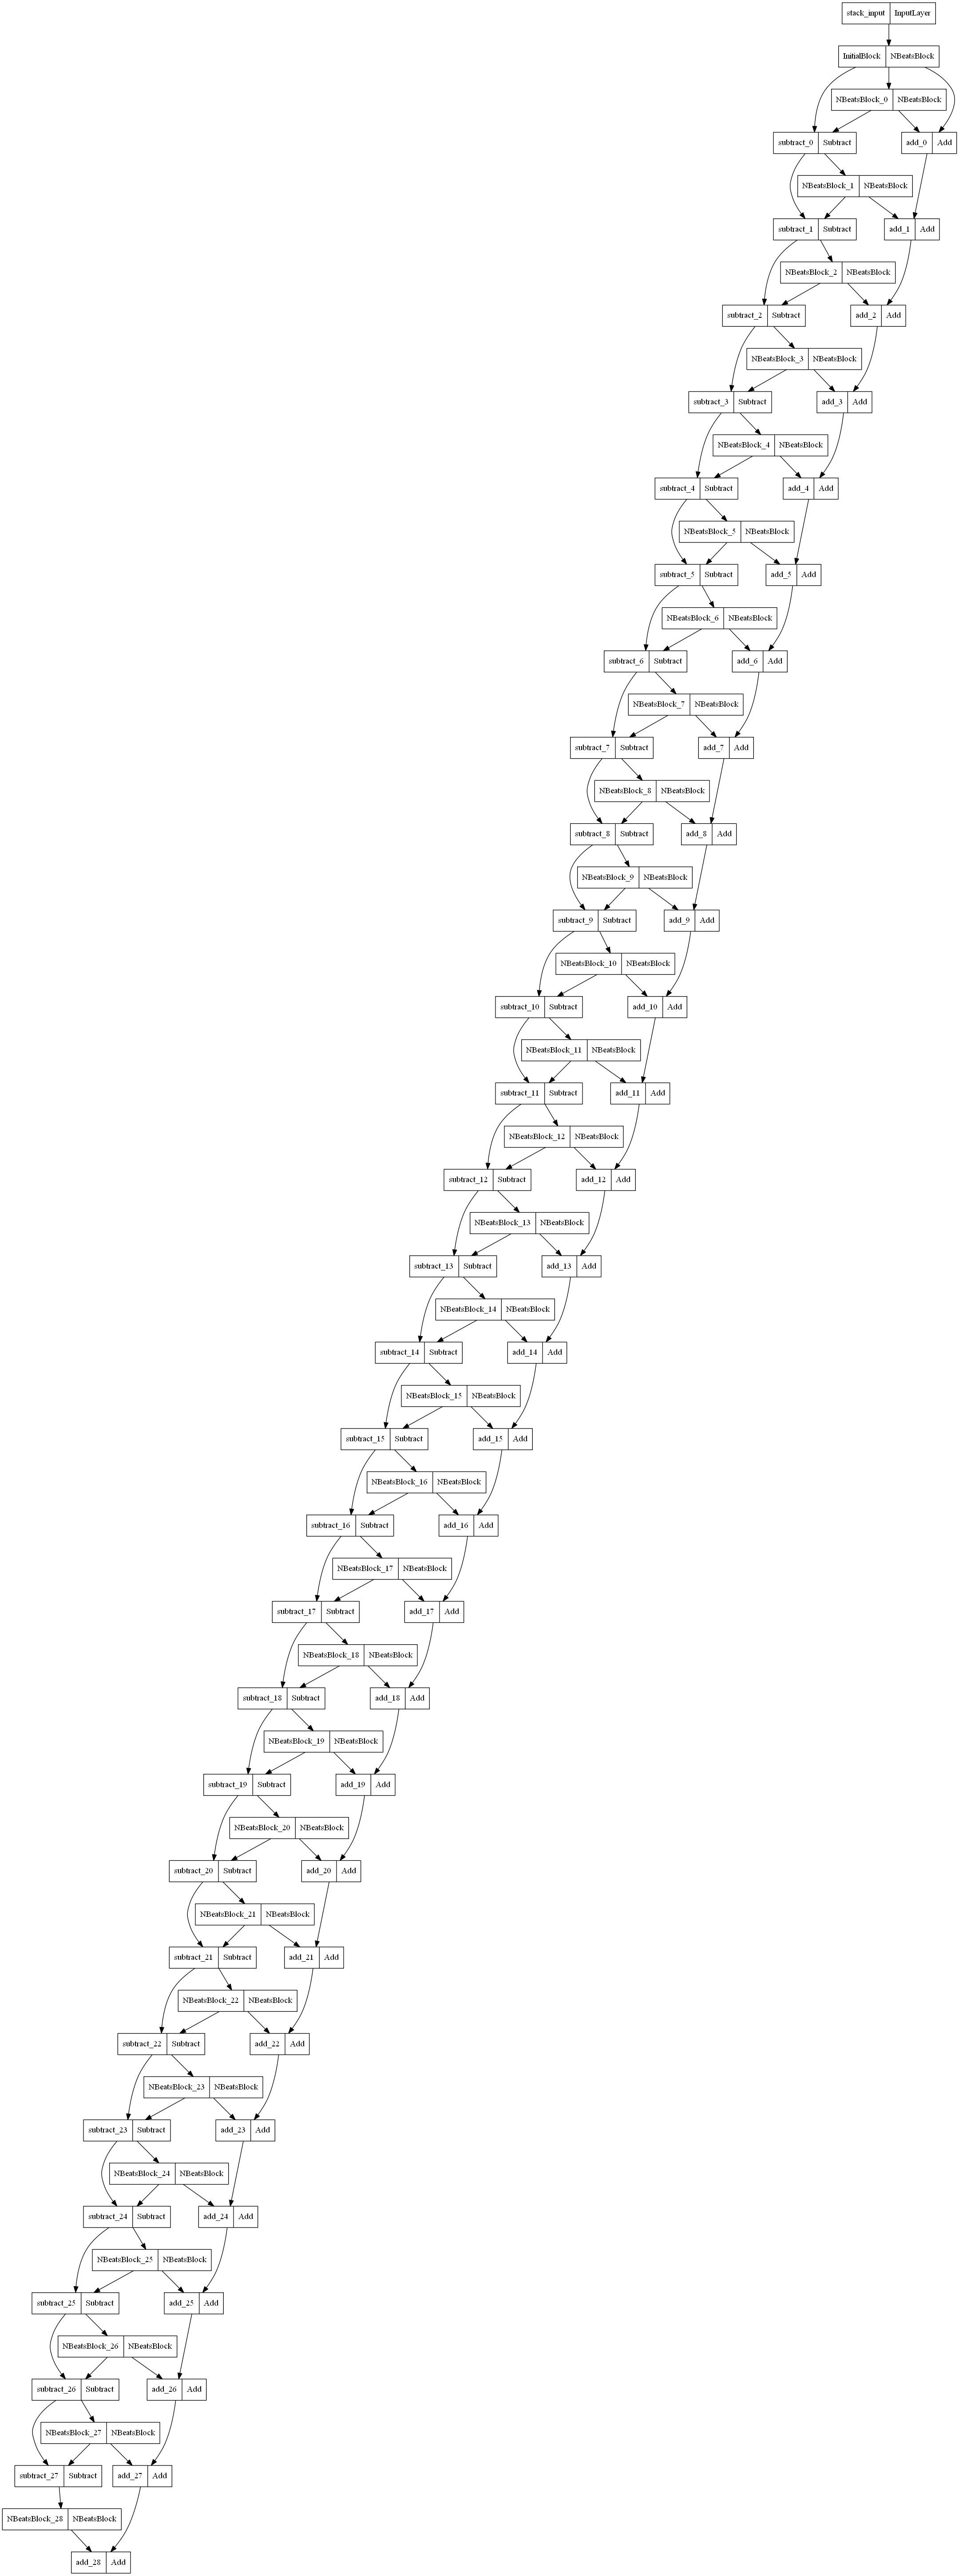

In [142]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [143]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting and ensemble of models (using different loss functions)

In [144]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=5,#3
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models 

In [145]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=10) #1000

Optimizing model by reducing: mae for 10 epochs, model number: 0
Optimizing model by reducing: mse for 10 epochs, model number: 0
Optimizing model by reducing: mape for 10 epochs, model number: 0
Optimizing model by reducing: mae for 10 epochs, model number: 1
Optimizing model by reducing: mse for 10 epochs, model number: 1
Optimizing model by reducing: mape for 10 epochs, model number: 1
Optimizing model by reducing: mae for 10 epochs, model number: 2
Optimizing model by reducing: mse for 10 epochs, model number: 2
Optimizing model by reducing: mape for 10 epochs, model number: 2
Optimizing model by reducing: mae for 10 epochs, model number: 3
Optimizing model by reducing: mse for 10 epochs, model number: 3
Optimizing model by reducing: mape for 10 epochs, model number: 3
Optimizing model by reducing: mae for 10 epochs, model number: 4
Optimizing model by reducing: mse for 10 epochs, model number: 4
Optimizing model by reducing: mape for 10 epochs, model number: 4
Wall time: 24.1 s


### Make predictions with our ensemble model

In [146]:
ensemble_models

In [148]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [150]:
# Create a list of ensemble predictions

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 53ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8968.153 ,  8838.264 ,  8216.773 , ..., 50537.38  , 47887.465 ,
        49295.535 ],
       [ 9964.499 ,  9825.381 ,  9509.954 , ..., 57017.37  , 53825.438 ,
        55172.46  ],
       [ 9164.732 ,  9045.534 ,  9211.341 , ..., 49444.26  , 48305.93  ,
        48739.395 ],
       ...,
       [ 8030.298 ,  7935.7754,  8414.775 , ..., 46627.293 , 48361.496 ,
        43240.906 ],
       [10584.153 , 10636.309 , 10688.612 , ..., 65797.39  , 65329.855 ,
        60640.332 ],
       [ 7874.8164,  7668.799 ,  7893.5166, ..., 39227.383 , 39355.715 ,
        39726.242 ]], dtype=float32)>

In [151]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8968.153 ,  8838.264 ,  8216.773 , ..., 50537.38  , 47887.465 ,
        49295.535 ],
       [ 9964.499 ,  9825.381 ,  9509.954 , ..., 57017.37  , 53825.438 ,
        55172.46  ],
       [ 9164.732 ,  9045.534 ,  9211.341 , ..., 49444.26  , 48305.93  ,
        48739.395 ],
       ...,
       [ 8030.298 ,  7935.7754,  8414.775 , ..., 46627.293 , 48361.496 ,
        43240.906 ],
       [10584.153 , 10636.309 , 10688.612 , ..., 65797.39  , 65329.855 ,
        60640.332 ],
       [ 7874.8164,  7668.799 ,  7893.5166, ..., 39227.383 , 39355.715 ,
        39726.242 ]], dtype=float32)>

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [152]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8897.428, 8864.794, 8770.566, 8700.976, 8732.627, 8506.199,
       8524.069, 8548.085, 8351.621, 8360.676], dtype=float32)>

In [153]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([9025.32 , 8838.264, 8711.023, 8872.875, 8849.244, 8806.488,
       8538.691, 8506.704, 8548.233, 8347.943], dtype=float32)

In [154]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 1003.7616,
 'mse': 2769315.0,
 'rmse': 1664.1259,
 'mape': 4.533381,
 'mase': 1.763331}

In [155]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 816.55383,
 'mse': 1985313.4,
 'rmse': 1409.0115,
 'mape': 3.6841557,
 'mase': 1.434459}

In [156]:
model_1_results

{'mae': 575.49493,
 'mse': 1188238.5,
 'rmse': 1090.0635,
 'mape': 2.5827935,
 'mase': 1.0109853}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialzed models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [157]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds 
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [158]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

> 📖 **Resource:** Many of the steps we've taken above have inspired/referenced from the Machine Learning Mastery blog post on [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

In [159]:
X_test.index[:10]

DatetimeIndex(['2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13',
               '2019-11-14', '2019-11-15', '2019-11-16', '2019-11-17',
               '2019-11-18', '2019-11-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

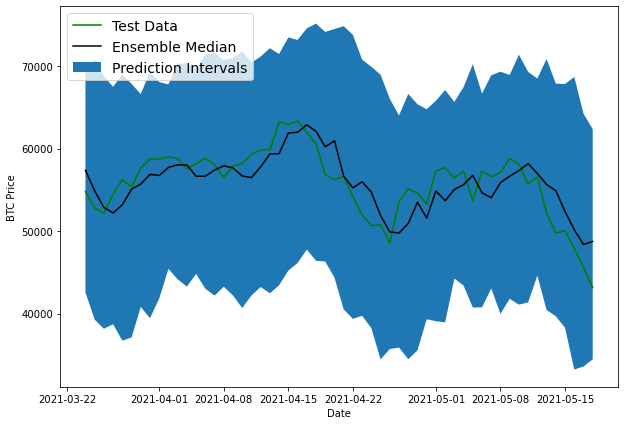

In [160]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm... 

So far all of our models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> 🔑 **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (what can a model never predict? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty

Weve only scratched the surface of uncertainty in machine but if you'd like to learn more, I'd highly recommend checking out the resources located here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#learning-more-on-uncertainty

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future!